In [1]:
import sys
sys.path.append('../')

# Datasets

We create a dataset by following the instructions [here](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/datasets.md#pix2pix-datasets)

In [10]:
from pathlib import Path

DATAROOT = Path('../data/output/denoiser')
FRAGMENTS_DIR = Path('../data/input/train')
REGION_SIZE = 512
SV = '28'

DATAROOT.mkdir(parents=True, exist_ok=True)
print('Dataroot:', DATAROOT)

Dataroot: ../data/output/denoiser


In [11]:
from sp.data.img2label import Img2LabelDataset

Img2LabelDataset.preprocess(
    REGION_SIZE,
    FRAGMENTS_DIR,
    outdir=DATAROOT,
    sample_path=f'surface_volume/{SV}.tif',
    label_path='ir.png',
    mask_samples_only=True,
    splits=[
        ('train', ['1', '2']),
        ('val', ['3']),
        ('test', ['3'])
    ])

Split: train:   0%|          | 0/2 [00:00<?, ?it/s]

Fold: 1:   0%|          | 0/208 [00:00<?, ?it/s]

Fold: 2:   0%|          | 0/551 [00:00<?, ?it/s]

Split: val:   0%|          | 0/1 [00:00<?, ?it/s]

Fold: 3:   0%|          | 0/165 [00:00<?, ?it/s]

Split: test:   0%|          | 0/1 [00:00<?, ?it/s]

Fold: 3:   0%|          | 0/165 [00:00<?, ?it/s]

Done!


[fold_A] =  ../data/output/denoiser/A
[fold_B] =  ../data/output/denoiser/B
[fold_AB] =  ../data/output/denoiser
[num_imgs] =  1000000
[use_AB] =  False
[no_multiprocessing] =  False
split = train, use 405/405 images
split = train, number of images = 405
split = val, use 68/68 images
split = val, number of images = 68
split = test, use 68/68 images
split = test, number of images = 68
A  B  __meta__	meta.json  test  train	val


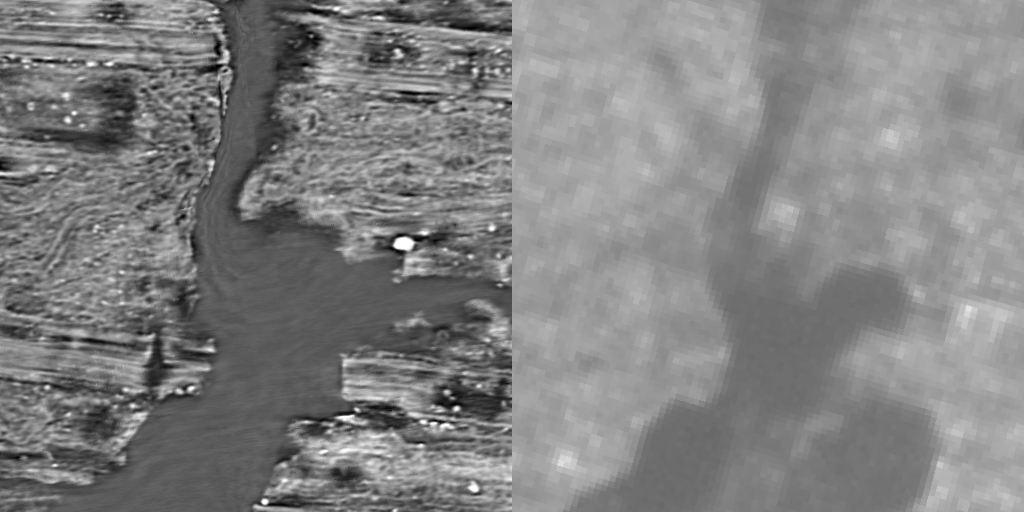

In [15]:
!python datasets/combine_A_and_B.py \
    --fold_A $DATAROOT/A \
    --fold_B $DATAROOT/B \
    --fold_AB $DATAROOT
!ls $DATAROOT

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

Image.open(DATAROOT / 'train/1.png')

# Pretrained models

Download one of the official pretrained models with:

-   `bash ./scripts/download_pix2pix_model.sh [edges2shoes, sat2map, map2sat, facades_label2photo, and day2night]`

Or add your own pretrained model to `./checkpoints/{NAME}_pretrained/latest_net_G.pt`

In [18]:
MODEL_NAME = 'xray2ir'

In [17]:
# NOTE: We use sat2map as that seems to be the most applicable...?
!bash ./scripts/download_pix2pix_model.sh sat2map

Note: available models are edges2shoes, sat2map, map2sat, facades_label2photo, and day2night
Specified [sat2map]
for details.

--2023-05-26 19:22:00--  http://efrosgans.eecs.berkeley.edu/pix2pix/models-pytorch/sat2map.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217704720 (208M)
Saving to: ‘./checkpoints/sat2map_pretrained/latest_net_G.pth’

./checkpoints/sat2m 100%[===================>] 207.62M  41.7MB/s    in 5.4s    

2023-05-26 19:22:05 (38.1 MB/s) - ‘./checkpoints/sat2map_pretrained/latest_net_G.pth’ saved [217704720/217704720]



In [20]:
!mkdir -p ./checkpoints/$MODEL_NAME
!cp ./checkpoints/sat2map_pretrained/latest_net_G.pth ./checkpoints/$MODEL_NAME/latest_net_G.pth
!ls ./checkpoints/$MODEL_NAME

latest_net_G.pth


# Training

-   `python train.py --dataroot ./datasets/facades --name facades_pix2pix --model pix2pix --direction BtoA`

Change the `--dataroot` and `--name` to your own dataset's path and model's name. Use `--gpu_ids 0,1,..` to train on multiple GPUs and `--batch_size` to change the batch size. Add `--direction BtoA` if you want to train a model to transfrom from class B to A.

In [24]:
!python train.py --dataroot $DATAROOT --name $MODEL_NAME --model pix2pix --gpu_ids 0

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ../data/output/denoiser       	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              



Could not connect to Visdom server. 
 Trying to start a server....
Command: /home/tony/.cache/pypoetry/virtualenvs/sp-LVeQk688-py3.10/bin/python -m visdom.server -p 8097 &>/dev/null &
create web directory ./checkpoints/xray2ir/web...
/home/tony/.cache/pypoetry/virtualenvs/sp-LVeQk688-py3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
learning rate 0.0002000 -> 0.0002000
(epoch: 1, iters: 100, time: 0.062, data: 0.105) G_GAN: 2.647 G_L1: 13.255 D_real: 0.121 D_fake: 0.213 
(epoch: 1, iters: 200, time:

(epoch: 15, iters: 330, time: 0.191, data: 0.001) G_GAN: 1.224 G_L1: 24.187 D_real: 0.000 D_fake: 0.690 
saving the model at the end of epoch 15, iters 6075
End of epoch 15 / 200 	 Time Taken: 16 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 16, iters: 25, time: 0.064, data: 0.001) G_GAN: 0.644 G_L1: 11.872 D_real: 0.386 D_fake: 1.591 
(epoch: 16, iters: 125, time: 0.066, data: 0.001) G_GAN: 2.278 G_L1: 15.278 D_real: 0.116 D_fake: 0.164 
(epoch: 16, iters: 225, time: 0.066, data: 0.001) G_GAN: 1.779 G_L1: 9.311 D_real: 1.588 D_fake: 0.132 
(epoch: 16, iters: 325, time: 0.190, data: 0.001) G_GAN: 2.406 G_L1: 26.806 D_real: 0.000 D_fake: 0.101 
End of epoch 16 / 200 	 Time Taken: 15 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 17, iters: 20, time: 0.065, data: 0.001) G_GAN: 1.469 G_L1: 16.932 D_real: 0.048 D_fake: 1.910 
(epoch: 17, iters: 120, time: 0.066, data: 0.001) G_GAN: 1.882 G_L1: 10.127 D_real: 0.485 D_fake: 0.124 
(epoch: 17, iters: 220, time: 0.064, data: 0.001) G_GAN:

(epoch: 31, iters: 250, time: 0.210, data: 0.001) G_GAN: 1.048 G_L1: 13.050 D_real: 1.374 D_fake: 0.258 
(epoch: 31, iters: 350, time: 0.064, data: 0.001) G_GAN: 0.959 G_L1: 10.666 D_real: 1.871 D_fake: 0.355 
End of epoch 31 / 200 	 Time Taken: 15 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 32, iters: 45, time: 0.063, data: 0.001) G_GAN: 1.649 G_L1: 11.143 D_real: 2.459 D_fake: 0.163 
(epoch: 32, iters: 145, time: 0.064, data: 0.001) G_GAN: 1.723 G_L1: 16.125 D_real: 0.078 D_fake: 0.290 
(epoch: 32, iters: 245, time: 0.207, data: 0.001) G_GAN: 1.146 G_L1: 9.710 D_real: 1.861 D_fake: 0.204 
(epoch: 32, iters: 345, time: 0.064, data: 0.001) G_GAN: 1.931 G_L1: 23.602 D_real: 0.000 D_fake: 0.198 
End of epoch 32 / 200 	 Time Taken: 15 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 33, iters: 40, time: 0.064, data: 0.001) G_GAN: 2.054 G_L1: 13.991 D_real: 0.096 D_fake: 0.196 
(epoch: 33, iters: 140, time: 0.064, data: 0.001) G_GAN: 2.020 G_L1: 12.575 D_real: 0.028 D_fake: 0.211 
(ep

(epoch: 47, iters: 270, time: 0.064, data: 0.001) G_GAN: 1.851 G_L1: 16.969 D_real: 0.055 D_fake: 0.357 
(epoch: 47, iters: 370, time: 0.064, data: 0.001) G_GAN: 1.819 G_L1: 11.509 D_real: 0.672 D_fake: 0.203 
End of epoch 47 / 200 	 Time Taken: 15 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 48, iters: 65, time: 0.064, data: 0.001) G_GAN: 1.587 G_L1: 11.789 D_real: 1.068 D_fake: 0.165 
(epoch: 48, iters: 165, time: 0.226, data: 0.001) G_GAN: 1.187 G_L1: 20.391 D_real: 0.274 D_fake: 0.920 
(epoch: 48, iters: 265, time: 0.063, data: 0.001) G_GAN: 0.742 G_L1: 9.287 D_real: 0.735 D_fake: 0.738 
(epoch: 48, iters: 365, time: 0.064, data: 0.001) G_GAN: 1.128 G_L1: 13.303 D_real: 0.123 D_fake: 0.551 
End of epoch 48 / 200 	 Time Taken: 15 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 49, iters: 60, time: 0.064, data: 0.001) G_GAN: 1.058 G_L1: 18.267 D_real: 0.015 D_fake: 0.801 
(epoch: 49, iters: 160, time: 0.232, data: 0.001) G_GAN: 1.429 G_L1: 10.565 D_real: 0.320 D_fake: 0.351 
(ep

(epoch: 63, iters: 190, time: 0.063, data: 0.001) G_GAN: 1.763 G_L1: 10.790 D_real: 0.030 D_fake: 0.958 
(epoch: 63, iters: 290, time: 0.064, data: 0.001) G_GAN: 1.390 G_L1: 11.502 D_real: 0.346 D_fake: 0.336 
(epoch: 63, iters: 390, time: 0.063, data: 0.001) G_GAN: 2.318 G_L1: 15.114 D_real: 0.080 D_fake: 0.184 
End of epoch 63 / 200 	 Time Taken: 15 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 64, iters: 85, time: 0.335, data: 0.001) G_GAN: 1.301 G_L1: 10.302 D_real: 0.868 D_fake: 0.273 
(epoch: 64, iters: 185, time: 0.064, data: 0.001) G_GAN: 1.685 G_L1: 15.351 D_real: 0.008 D_fake: 0.286 
(epoch: 64, iters: 285, time: 0.063, data: 0.001) G_GAN: 1.488 G_L1: 14.546 D_real: 0.139 D_fake: 0.514 
(epoch: 64, iters: 385, time: 0.063, data: 0.001) G_GAN: 1.240 G_L1: 11.650 D_real: 1.023 D_fake: 0.238 
End of epoch 64 / 200 	 Time Taken: 15 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 65, iters: 80, time: 0.245, data: 0.001) G_GAN: 2.150 G_L1: 16.121 D_real: 0.006 D_fake: 0.195 
(e

(epoch: 79, iters: 210, time: 0.064, data: 0.001) G_GAN: 1.083 G_L1: 8.390 D_real: 0.537 D_fake: 0.723 
(epoch: 79, iters: 310, time: 0.064, data: 0.001) G_GAN: 1.078 G_L1: 8.247 D_real: 0.792 D_fake: 0.349 
End of epoch 79 / 200 	 Time Taken: 15 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 80, iters: 5, time: 0.267, data: 0.001) G_GAN: 1.531 G_L1: 8.628 D_real: 0.441 D_fake: 0.191 
(epoch: 80, iters: 105, time: 0.065, data: 0.000) G_GAN: 1.425 G_L1: 12.937 D_real: 0.030 D_fake: 0.624 
(epoch: 80, iters: 205, time: 0.064, data: 0.001) G_GAN: 1.255 G_L1: 13.465 D_real: 0.223 D_fake: 0.391 
(epoch: 80, iters: 305, time: 0.064, data: 0.001) G_GAN: 1.460 G_L1: 12.951 D_real: 0.038 D_fake: 0.661 
(epoch: 80, iters: 405, time: 0.123, data: 0.001) G_GAN: 2.550 G_L1: 12.952 D_real: 0.313 D_fake: 0.099 
saving the model at the end of epoch 80, iters 32400
End of epoch 80 / 200 	 Time Taken: 16 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 81, iters: 100, time: 0.064, data: 0.083) G_GAN: 

(epoch: 95, iters: 230, time: 0.064, data: 0.001) G_GAN: 1.368 G_L1: 9.791 D_real: 1.020 D_fake: 0.258 
(epoch: 95, iters: 330, time: 0.277, data: 0.001) G_GAN: 1.112 G_L1: 13.497 D_real: 0.147 D_fake: 0.760 
saving the model at the end of epoch 95, iters 38475
End of epoch 95 / 200 	 Time Taken: 16 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 96, iters: 25, time: 0.063, data: 0.001) G_GAN: 0.978 G_L1: 6.990 D_real: 0.839 D_fake: 0.441 
(epoch: 96, iters: 125, time: 0.063, data: 0.001) G_GAN: 1.277 G_L1: 10.903 D_real: 0.374 D_fake: 0.364 
(epoch: 96, iters: 225, time: 0.063, data: 0.001) G_GAN: 0.957 G_L1: 10.247 D_real: 1.314 D_fake: 0.413 
(epoch: 96, iters: 325, time: 0.275, data: 0.001) G_GAN: 1.533 G_L1: 10.454 D_real: 0.614 D_fake: 0.366 
End of epoch 96 / 200 	 Time Taken: 15 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 97, iters: 20, time: 0.063, data: 0.001) G_GAN: 1.267 G_L1: 10.773 D_real: 0.210 D_fake: 0.698 
(epoch: 97, iters: 120, time: 0.064, data: 0.001) G_GAN:

(epoch: 111, iters: 150, time: 0.063, data: 0.001) G_GAN: 1.519 G_L1: 11.620 D_real: 0.077 D_fake: 0.473 
(epoch: 111, iters: 250, time: 0.294, data: 0.001) G_GAN: 0.967 G_L1: 8.558 D_real: 0.840 D_fake: 0.480 
(epoch: 111, iters: 350, time: 0.066, data: 0.001) G_GAN: 1.453 G_L1: 10.605 D_real: 0.155 D_fake: 0.547 
End of epoch 111 / 200 	 Time Taken: 15 sec
learning rate 0.0001762 -> 0.0001743
(epoch: 112, iters: 45, time: 0.065, data: 0.001) G_GAN: 1.055 G_L1: 7.971 D_real: 0.662 D_fake: 0.389 
saving the latest model (epoch 112, total_iters 45000)
(epoch: 112, iters: 145, time: 0.067, data: 0.001) G_GAN: 0.995 G_L1: 10.388 D_real: 1.091 D_fake: 0.382 
(epoch: 112, iters: 245, time: 0.298, data: 0.001) G_GAN: 0.896 G_L1: 11.201 D_real: 0.406 D_fake: 0.871 
(epoch: 112, iters: 345, time: 0.065, data: 0.001) G_GAN: 0.755 G_L1: 9.625 D_real: 0.835 D_fake: 0.656 
End of epoch 112 / 200 	 Time Taken: 16 sec
learning rate 0.0001743 -> 0.0001723
(epoch: 113, iters: 40, time: 0.066, data: 0.

End of epoch 126 / 200 	 Time Taken: 15 sec
learning rate 0.0001465 -> 0.0001446
(epoch: 127, iters: 70, time: 0.064, data: 0.001) G_GAN: 0.977 G_L1: 9.237 D_real: 0.864 D_fake: 0.448 
(epoch: 127, iters: 170, time: 0.404, data: 0.001) G_GAN: 1.034 G_L1: 11.613 D_real: 0.470 D_fake: 0.603 
(epoch: 127, iters: 270, time: 0.063, data: 0.001) G_GAN: 1.201 G_L1: 7.516 D_real: 1.128 D_fake: 0.319 
(epoch: 127, iters: 370, time: 0.064, data: 0.001) G_GAN: 1.280 G_L1: 10.714 D_real: 0.754 D_fake: 0.345 
End of epoch 127 / 200 	 Time Taken: 15 sec
learning rate 0.0001446 -> 0.0001426
(epoch: 128, iters: 65, time: 0.066, data: 0.001) G_GAN: 1.205 G_L1: 8.598 D_real: 0.166 D_fake: 0.662 
(epoch: 128, iters: 165, time: 0.310, data: 0.001) G_GAN: 0.859 G_L1: 8.989 D_real: 0.338 D_fake: 0.668 
(epoch: 128, iters: 265, time: 0.064, data: 0.001) G_GAN: 1.331 G_L1: 11.368 D_real: 0.083 D_fake: 0.471 
(epoch: 128, iters: 365, time: 0.064, data: 0.001) G_GAN: 0.917 G_L1: 6.524 D_real: 0.923 D_fake: 0.47

(epoch: 142, iters: 395, time: 0.066, data: 0.001) G_GAN: 1.387 G_L1: 8.926 D_real: 0.377 D_fake: 0.360 
End of epoch 142 / 200 	 Time Taken: 15 sec
learning rate 0.0001149 -> 0.0001129
(epoch: 143, iters: 90, time: 0.338, data: 0.001) G_GAN: 2.503 G_L1: 8.765 D_real: 0.741 D_fake: 0.105 
(epoch: 143, iters: 190, time: 0.064, data: 0.001) G_GAN: 2.730 G_L1: 8.892 D_real: 0.418 D_fake: 0.235 
(epoch: 143, iters: 290, time: 0.065, data: 0.001) G_GAN: 2.506 G_L1: 8.547 D_real: 0.378 D_fake: 0.186 
(epoch: 143, iters: 390, time: 0.066, data: 0.001) G_GAN: 1.835 G_L1: 8.334 D_real: 0.416 D_fake: 0.254 
End of epoch 143 / 200 	 Time Taken: 15 sec
learning rate 0.0001129 -> 0.0001109
(epoch: 144, iters: 85, time: 0.326, data: 0.001) G_GAN: 2.020 G_L1: 10.177 D_real: 0.040 D_fake: 0.679 
(epoch: 144, iters: 185, time: 0.066, data: 0.001) G_GAN: 3.273 G_L1: 10.796 D_real: 0.649 D_fake: 0.141 
(epoch: 144, iters: 285, time: 0.064, data: 0.001) G_GAN: 2.226 G_L1: 8.409 D_real: 0.330 D_fake: 0.151

(epoch: 158, iters: 315, time: 0.064, data: 0.001) G_GAN: 2.012 G_L1: 7.532 D_real: 0.140 D_fake: 0.285 
End of epoch 158 / 200 	 Time Taken: 15 sec
learning rate 0.0000832 -> 0.0000812
(epoch: 159, iters: 10, time: 0.341, data: 0.001) G_GAN: 2.518 G_L1: 7.852 D_real: 0.057 D_fake: 0.213 
(epoch: 159, iters: 110, time: 0.063, data: 0.001) G_GAN: 2.768 G_L1: 9.409 D_real: 0.276 D_fake: 0.061 
(epoch: 159, iters: 210, time: 0.064, data: 0.001) G_GAN: 2.082 G_L1: 10.113 D_real: 0.833 D_fake: 0.943 
(epoch: 159, iters: 310, time: 0.064, data: 0.001) G_GAN: 1.656 G_L1: 8.143 D_real: 0.448 D_fake: 0.236 
End of epoch 159 / 200 	 Time Taken: 15 sec
learning rate 0.0000812 -> 0.0000792
(epoch: 160, iters: 5, time: 0.448, data: 0.001) G_GAN: 0.895 G_L1: 8.257 D_real: 0.917 D_fake: 0.768 
(epoch: 160, iters: 105, time: 0.064, data: 0.000) G_GAN: 3.028 G_L1: 6.145 D_real: 0.425 D_fake: 0.076 
(epoch: 160, iters: 205, time: 0.066, data: 0.001) G_GAN: 2.820 G_L1: 10.016 D_real: 0.605 D_fake: 0.303 

# Testing

-   `python test.py --dataroot ./datasets/facades --direction BtoA --model pix2pix --name facades_pix2pix`

Change the `--dataroot`, `--name`, and `--direction` to be consistent with your trained model's configuration and how you want to transform images.

> from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix:
> Note that we specified --direction BtoA as Facades dataset's A to B direction is photos to labels.

> If you would like to apply a pre-trained model to a collection of input images (rather than image pairs), please use --model test option. See ./scripts/test_single.sh for how to apply a model to Facade label maps (stored in the directory facades/testB).

> See a list of currently available models at ./scripts/download_pix2pix_model.sh

In [27]:
!ls checkpoints/$MODEL_NAME

100_net_D.pth  130_net_G.pth  165_net_D.pth  50_net_G.pth  85_net_D.pth
100_net_G.pth  135_net_D.pth  165_net_G.pth  55_net_D.pth  85_net_G.pth
105_net_D.pth  135_net_G.pth  20_net_D.pth   55_net_G.pth  90_net_D.pth
105_net_G.pth  140_net_D.pth  20_net_G.pth   5_net_D.pth   90_net_G.pth
10_net_D.pth   140_net_G.pth  25_net_D.pth   5_net_G.pth   95_net_D.pth
10_net_G.pth   145_net_D.pth  25_net_G.pth   60_net_D.pth  95_net_G.pth
110_net_D.pth  145_net_G.pth  30_net_D.pth   60_net_G.pth  latest_net_D.pth
110_net_G.pth  150_net_D.pth  30_net_G.pth   65_net_D.pth  latest_net_G.pth
115_net_D.pth  150_net_G.pth  35_net_D.pth   65_net_G.pth  loss_log.txt
115_net_G.pth  155_net_D.pth  35_net_G.pth   70_net_D.pth  train_opt.txt
120_net_D.pth  155_net_G.pth  40_net_D.pth   70_net_G.pth  web
120_net_G.pth  15_net_D.pth   40_net_G.pth   75_net_D.pth
125_net_D.pth  15_net_G.pth   45_net_D.pth   75_net_G.pth
125_net_G.pth  160_net_D.pth  45_net_G.pth   80_net_D.pth
130_net_D.pth  160_net_G.pth  50_n

In [28]:
!python test.py --dataroot $DATAROOT --model pix2pix --name $MODEL_NAME

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../data/output/denoiser       	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

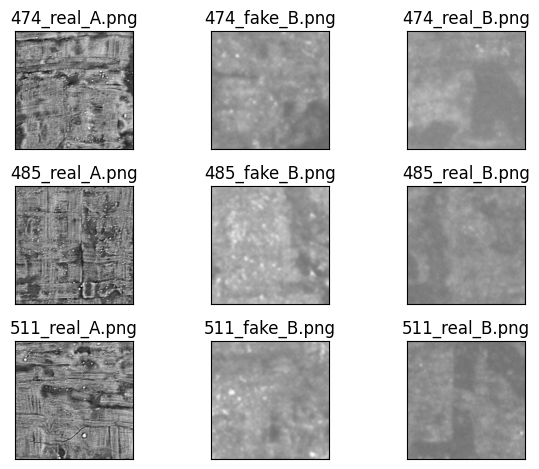

In [40]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3)

SAMPLES = [474, 485, 511]

for j, s in enumerate(SAMPLES):    
    for i, fname in enumerate([f'{s}_real_A.png', f'{s}_fake_B.png', f'{s}_real_B.png']):
        img = plt.imread(f'./results/{MODEL_NAME}/test_latest/images/{fname}')
        ax = axs[j][i]
        ax.imshow(img)
        ax.set(yticks=[], yticklabels=[], xticks=[], xticklabels=[], title=fname)

fig.tight_layout()
plt.show()

# Model Export + Test

In [41]:
# TODO